## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

In [4]:
# Read all the chessboard images in for camera calibration
filenames = []
for filename in glob.glob('camera_cal/calibration*'):
    filenames.append(filename)

In [55]:
def camera_calibration(filename, nx=9, ny=6):
    image = cv2.imread(filename)
    # Grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Find corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    # Draw corners and display
    if ret == True:
        
        cv2.drawChessboardCorners(image, (nx, ny), corners, ret)
        #objpoints and imgpoints
        objpoints = []
        imgpoints = []

        objp = np.zeros((nx*ny,3), np.float32)
        objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

        objpoints.append(objp)
        imgpoints.append(corners)
        # Undistory image
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (gray.shape[1], gray.shape[0]), None, None)
        undist = cv2.undistort(image, mtx, dist, None, mtx)
        # Plot image
        plt.figure()
        plt.imshow(undist)
    else:
        print('No Corners Found')

In [56]:
objpoints = []
imgpoints = []

objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

objpoints.append(objp)

No Corners Found
No Corners Found
No Corners Found


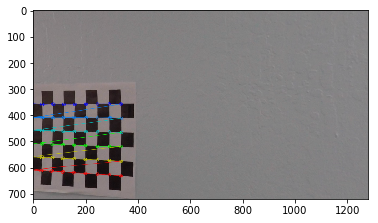

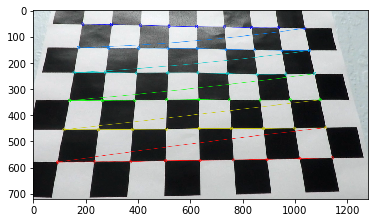

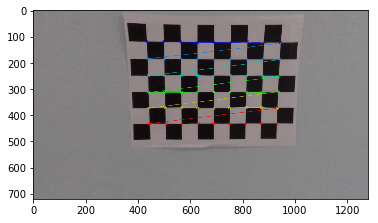

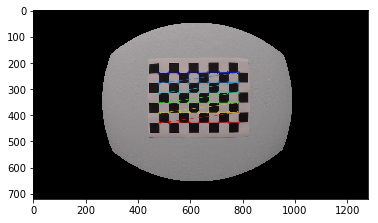

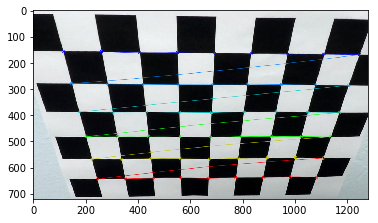

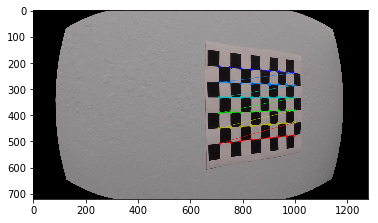

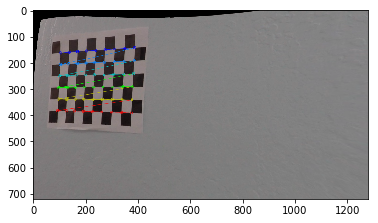

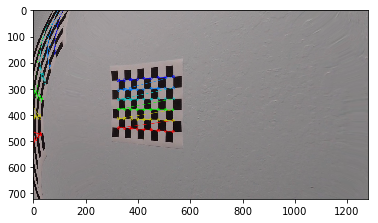

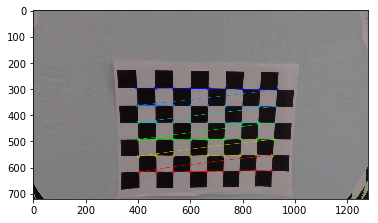

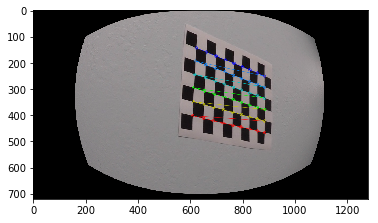

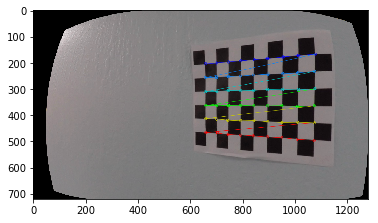

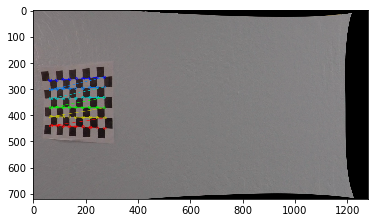

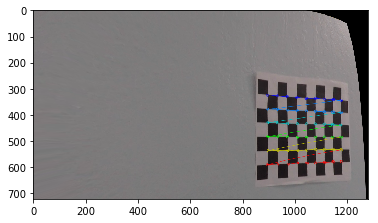

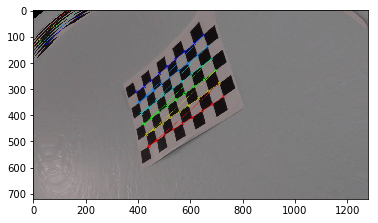

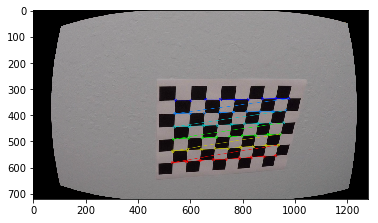

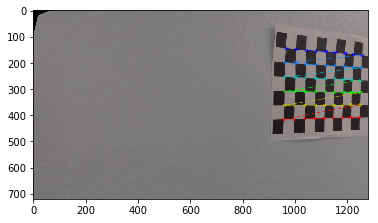

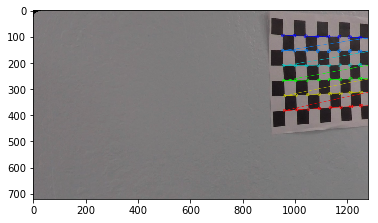

In [57]:
for i in range(len(filenames)):
    camera_calibration(filenames[i])